## **📝 Facial Emotion Recognition Analysis**

This notebook demonstrates a pipeline for facial emotion classification using image data and deep learning (CNN) Along with some Traditional simpler Models. The main objective is to classify facial images into different emotion categories accurately.



Dataset Source: https://www.kaggle.com/datasets/noamsegal/affectnet-training-
data/data?select=labels.csv

Data Characteristics:
* Images resized to 96x96 pixels for efficient processing.

* Total images: 29,000 categorized into 8 distinct emotions.

* reLFCs: Preprocessed using Principal Component Analysis (PCA) with a threshold on the Percentage of First Component (PFC%) to remove near-monochromatic (low-detail) images.

In [2]:
import os
import numpy as np
import pandas as pd
from tensorflow.keras.preprocessing import image
from tqdm import tqdm
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd

**2. Loading Direct Image Can Take a toll in mermory and can take multiple hours with larger data set so....**

*   Loaded all the images converted each images to numpy array and scaled and labeled **X[]** as images and **Y[]** as each unique class
*   Converted them to grayscale because with RGB I had over 8000 millions features to work with.
* Saved to .npz file to load faster.



In [3]:
from google.colab import drive
drive.mount('/content/drive')

import numpy as np
data = np.load('/content/drive/MyDrive/gray_image_data.npz')


Mounted at /content/drive


In [23]:
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.neural_network import MLPClassifier
from sklearn.preprocessing import LabelEncoder
from sklearn.decomposition import PCA
from sklearn.model_selection import cross_val_score

# 📊 Dataset Overview and Class Distribution
We begin by loading the dataset from a .csv file and exploring its structure. This includes:



1.   Viewing the first few rows to understand the format.

2. Displaying column names and basic summary statistics.

3. Plotting the class distribution to check for imbalance in the dataset.


In [4]:
path = '/content/drive/MyDrive/DataScienceW25/project/Facial_Expressions_Trainging_Data/'
data = f"{path}/labels.csv"
df = pd.read_csv(data)
df = df.drop(columns='Unnamed: 0')
print(df.head(5))
df.info()
df.describe()


                      pth     label    relFCs
0  anger/image0000006.jpg  surprise  0.873142
1  anger/image0000060.jpg     anger  0.852311
2  anger/image0000061.jpg     anger  0.800957
3  anger/image0000066.jpg   disgust  0.843079
4  anger/image0000106.jpg     anger  0.849108
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 28175 entries, 0 to 28174
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   pth     28175 non-null  object 
 1   label   28175 non-null  object 
 2   relFCs  28175 non-null  float64
dtypes: float64(1), object(2)
memory usage: 660.5+ KB


,relFCs
count,28175.000000
mean,0.799247
std,0.058755
min,0.516357
25%,0.766363
50%,0.809000
75%,0.842068
max,0.899951


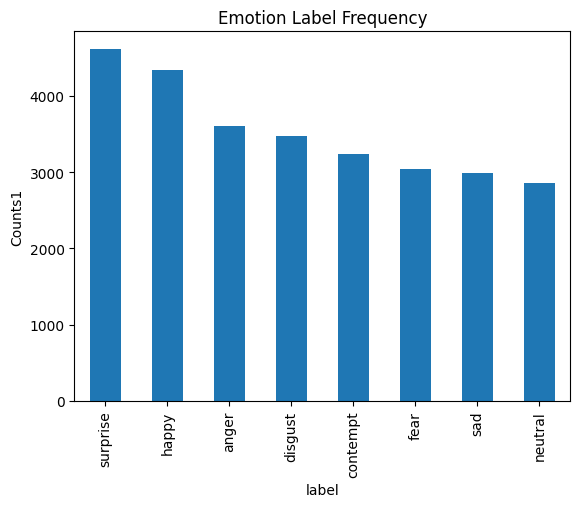

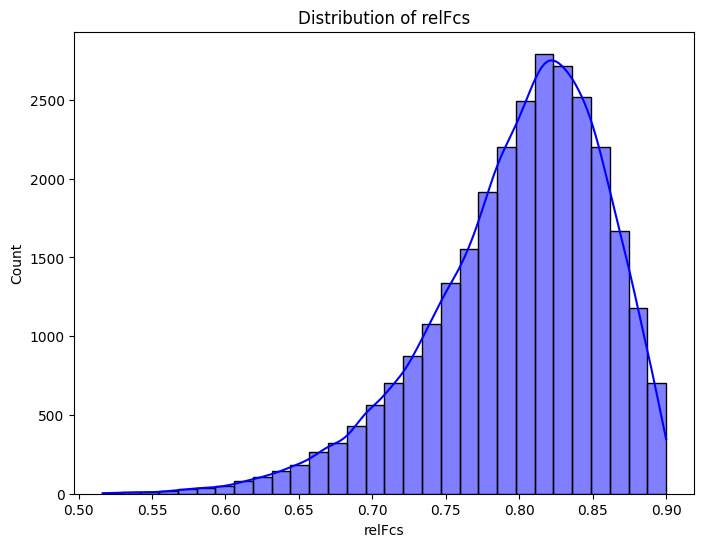

In [5]:
import matplotlib.pyplot as plt

df["label"].value_counts().plot(kind="bar") # The frequency of the data is good as everything is pretty labled..
plt.title("Emotion Label Frequency")
plt.ylabel("Counts1")
plt.show()

import seaborn as sns

# Histogram
plt.figure(figsize=(8, 6))
sns.histplot(df["relFCs"], bins=30, kde=True, color="blue")  # KDE adds smooth curve
plt.title("Distribution of relFcs")
plt.xlabel("relFcs")
plt.ylabel("Count")
plt.show()

# 📌 1. Data Loading
* Due to Loading time complications of large Image Dataset - Converted to numpy array
 * X =['image_features_scaaled']
 * Y = ['labels'] and saved to .npz file for ease loading.
* Rgb turned to grayscale and the vector features reduced to (1000 pca) components for smoother processing**
* Each Numpy images scaled to 1 and Classes transformed to int type from string **
* Splitting data for Traing and Testing **(80/20).**

In [24]:
# 1. Loading compressed .npz file
X = data['X']
y = data['Y']

print(f"Loaded data: {X.shape}, Labels: {y.shape}")

# 2. Defineing a batch generator
def npz_batch_generator(X, y, batch_size=1000):
    for i in range(0, len(X), batch_size):
        yield X[i:i+batch_size], y[i:i+batch_size]

# 3. Loading in manageable chunks and combining
X_batches, y_batches = [], []

for X_batch, y_batch in npz_batch_generator(X, y, batch_size=3000):  # 3k at a time
    X_batches.append(X_batch)
    y_batches.append(y_batch)

X_combined = np.vstack(X_batches)
y_combined = np.concatenate(y_batches)

# Flatten for sklearn models
X_flat = X_combined.reshape(X_combined.shape[0], -1)
le = LabelEncoder()
y_combined = le.fit_transform(y_combined)

# 4. Train-test split
X_train, X_test, y_train, y_test = train_test_split(
    X_flat, y_combined, test_size=0.2, stratify=y_combined, random_state=42
)

# 5. Standardize
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# pca
pca = PCA(n_components = 1000) # increased from 100 to 1000 So it can keep meaning ful features but increased computation massively for SVM (Specifically)
X_train_scaled = pca.fit_transform(X_train_scaled)
X_test_scaled = pca.transform(X_test_scaled)

Loaded data: (29042, 96, 96, 1), Labels: (29042,)


# 🤖 3. Train Simple Classifiers
Now, let's train some classic classifiers and check their cross validation score with **5 folds** and Compare!

***SVM was removed because of its quadratic optimization it took more than 3 hours with 1000 pca component***

In [25]:
# 6. Define and train models
models = {
    'Logistic Regression': LogisticRegression(C=0.1,                     # Smaller value = stronger regularization
    penalty='l2',              # Ridge regularization
    solver='lbfgs',
    max_iter=3000,
    class_weight='balanced',   # Handles imbalance
    random_state=42),
    'Random Forest': RandomForestClassifier(
    n_estimators=300,          # Increaed number of trees due to low cv
    max_depth=20,              # Limited depth to prevent overfitting
    min_samples_split=5,       # Controls growth of trees
    class_weight='balanced',   # Handle class imbalance
    random_state=42),

    'Neural Network': MLPClassifier(
    hidden_layer_sizes=(256, 128, 64),  # More neurons/layers
    activation='relu',
    alpha=0.001,                        # L2 penalty for generalization
    learning_rate='adaptive',          # Adjusts during training
    max_iter=2000,
    early_stopping=True,               # Stops if no improvement
    random_state=42
)

}

from sklearn.model_selection import cross_val_score
from sklearn.metrics import accuracy_score

results = {}

for name, model in models.items():
    # Cross-validation on training data
    scores = cross_val_score(model, X_train_scaled, y_train, cv=5)

    results[name] = {
        'mean_accuracy': scores.mean(),
        'std_accuracy': scores.std(),
        'model': model
    }

    print(f"{name} Cross-Validation Accuracy: {scores.mean():.4f} ± {scores.std():.4f}")

# 🔍 Find best model by mean accuracy
best_model_name = max(results, key=lambda x: results[x]['mean_accuracy'])
best_model = results[best_model_name]['model']
print(f"\nBest model: {best_model_name}")


Logistic Regression Cross-Validation Accuracy: 0.4712 ± 0.0132
Random Forest Cross-Validation Accuracy: 0.3929 ± 0.0044
Neural Network Cross-Validation Accuracy: 0.4820 ± 0.0108

Best model: Neural Network


🔍 2. Data Clustering: Feature Space vs. Embedding Space
We’ll explore Confusion-Matrix for each modle to find where modle gets tricked and apply unsupervised learning by applying K-Means clustering and visualizing the clusters using PCA and t-SNE to the embedding of MPL. 🎨


Training and Confusion Matrix for Logistic Regression


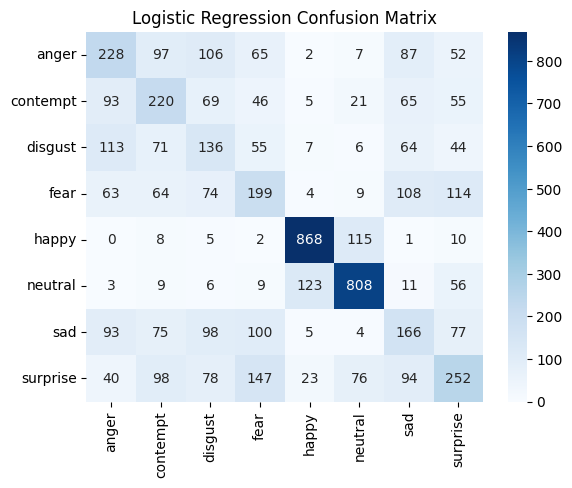


Training and Confusion Matrix for Random Forest


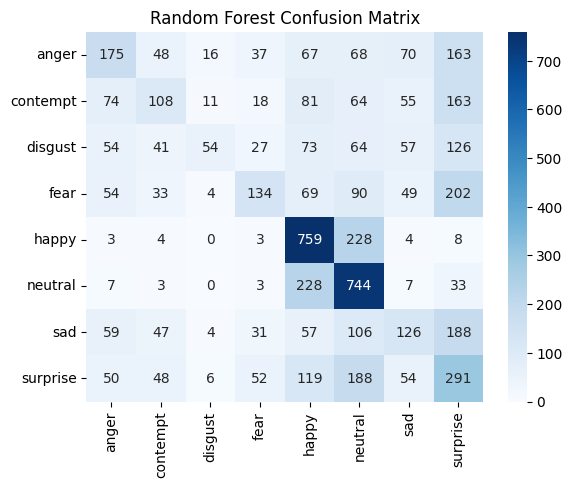


Training and Confusion Matrix for Neural Network


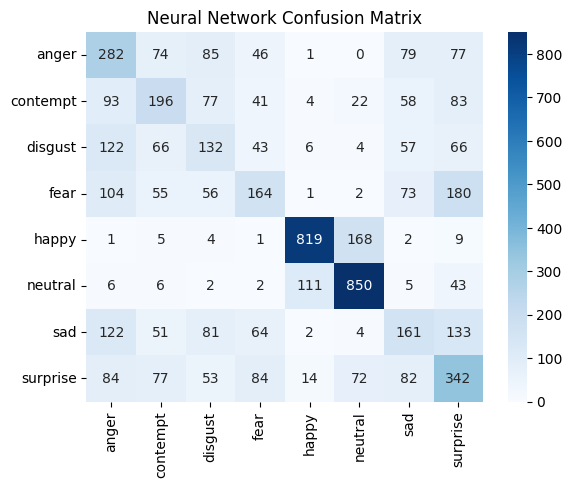

In [26]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

for name, info in results.items():
    print(f"\nTraining and Confusion Matrix for {name}")

    model = info['model']
    model.fit(X_train_scaled, y_train)  # Fit the model
    y_pred = model.predict(X_test_scaled)  # Predict on test data

    # Confusion Matrix
    cm = confusion_matrix(y_test, y_pred)


    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=le.classes_,
            yticklabels=le.classes_)

    plt.title(f"{name} Confusion Matrix")
    plt.show()


# * PCA Class Cluster Visualization

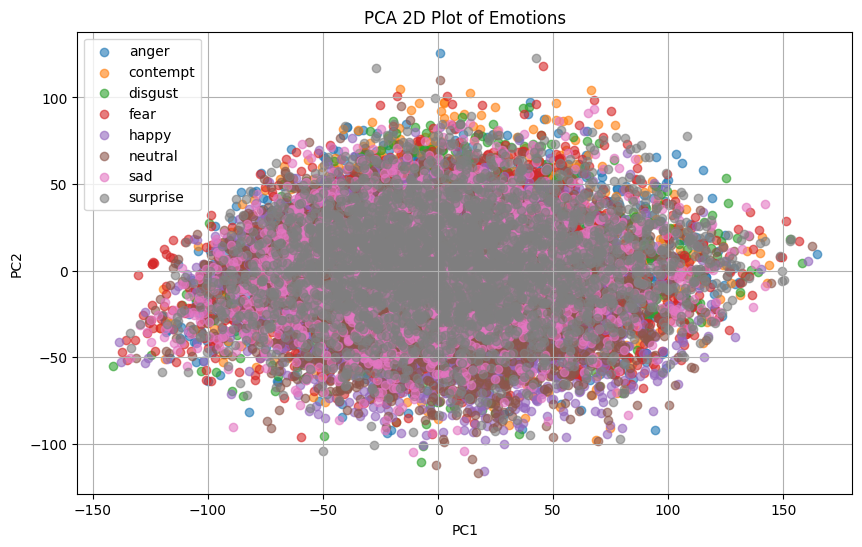

In [27]:
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

pca = PCA(n_components=2)
X_2D = pca.fit_transform(X_train_scaled)

plt.figure(figsize=(10, 6))
for i in np.unique(y_train):
    plt.scatter(X_2D[y_train == i, 0], X_2D[y_train == i, 1], label=le.classes_[i], alpha=0.6)
plt.title("PCA 2D Plot of Emotions")
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.legend()
plt.grid(True)
plt.show()


# **MlP Classifier to learn how well the modle learns and extrating embedding for unsupervised visual plotting **

In [28]:
from sklearn.neural_network import MLPClassifier

X_flat = X.reshape(X.shape[0], -1)  # (29042, 9216)

# Encode labels numerically
le = LabelEncoder()
y_encoded = le.fit_transform(y)

# Standardize inputs
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_flat)

# Deeper MLP with more expressive capacity
mlp_model = MLPClassifier(hidden_layer_sizes=(256, 128), max_iter=500, random_state=42)
mlp_model.fit(X_scaled, y_encoded)

def extract_mlp_embedding(model, X_input):
    n_layers = len(model.coefs_)
    layer_output = X_input

    for i in range(n_layers - 1):  # skip the final output layer
        layer_output = np.maximum(0, np.dot(layer_output, model.coefs_[i]) + model.intercepts_[i])  # ReLU
    return layer_output

X_embed = extract_mlp_embedding(mlp_model, X_scaled)
print("Embedding shape:", X_embed.shape)  # should be (29042, 64)


Embedding shape: (29042, 128)


**KMeans linear vizualization**

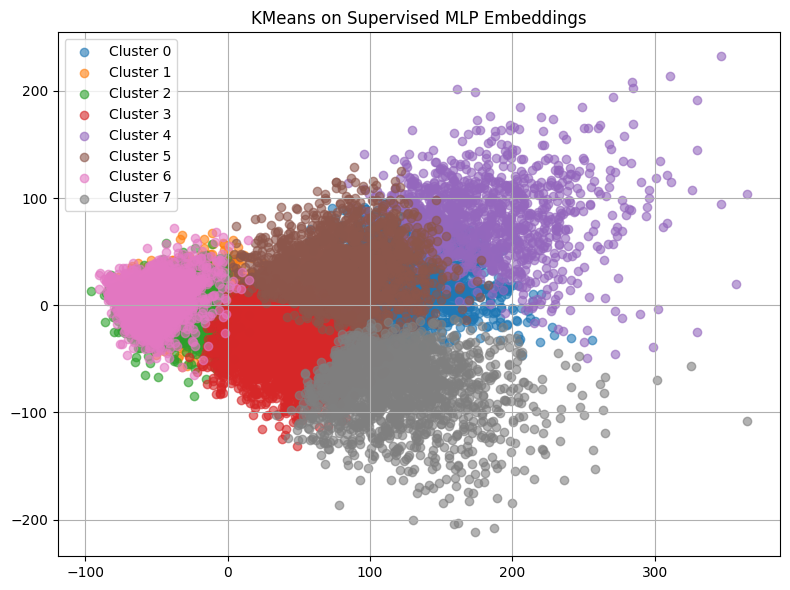

In [29]:
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA

pca = PCA(n_components=2)
X_embed_2d = pca.fit_transform(X_embed)
kmeans = KMeans(n_clusters=len(np.unique(y_encoded)), random_state=42)
cluster_labels = kmeans.fit_predict(X_embed)

# Plot cluster results
plt.figure(figsize=(8, 6))
for i in np.unique(cluster_labels):
    plt.scatter(X_embed_2d[cluster_labels == i, 0], X_embed_2d[cluster_labels == i, 1], label=f'Cluster {i}', alpha=0.6)
plt.title("KMeans on Supervised MLP Embeddings")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


**True Emotions vizualization for comparing how well the model learned**

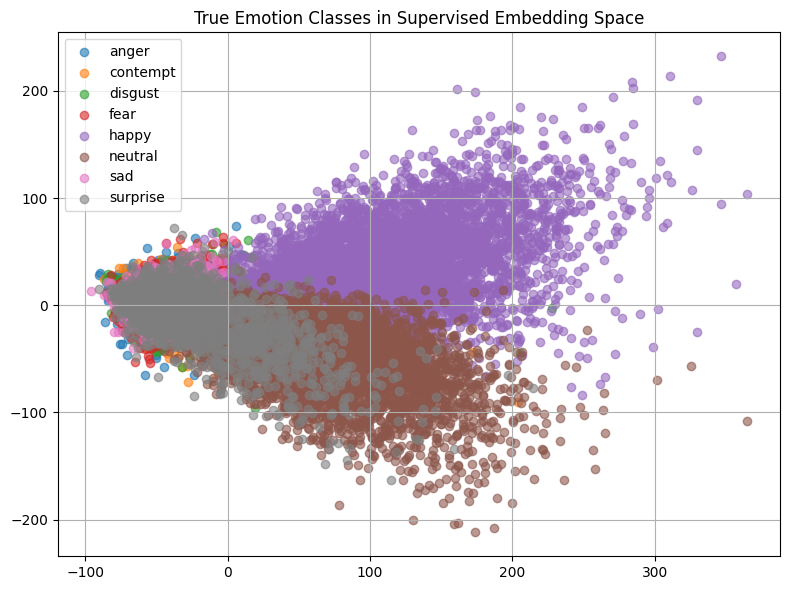

In [30]:
plt.figure(figsize=(8, 6))
for i in np.unique(y_encoded):
    plt.scatter(X_embed_2d[y_encoded == i, 0], X_embed_2d[y_encoded == i, 1], label=le.classes_[i], alpha=0.6)
plt.title("True Emotion Classes in Supervised Embedding Space")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


***Tsne and UMap With varying neighbours and perplexity For non-linear vizualization***

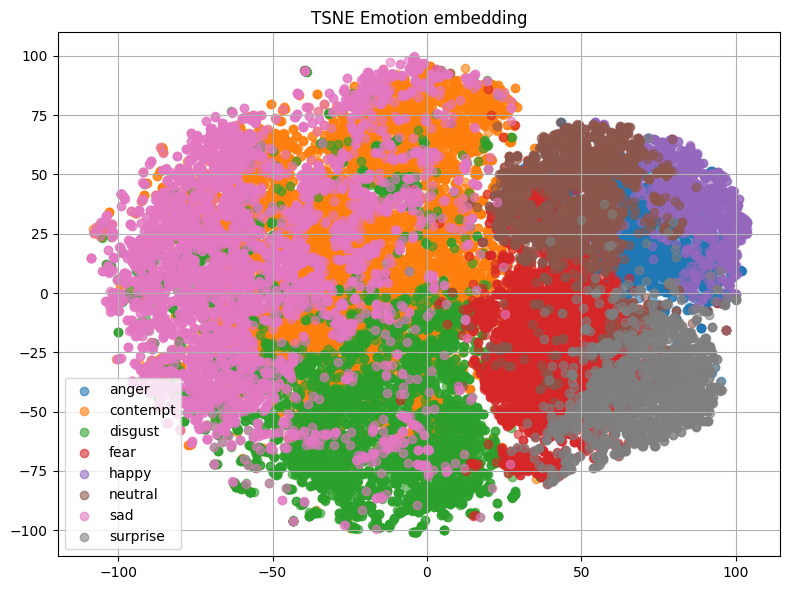

/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


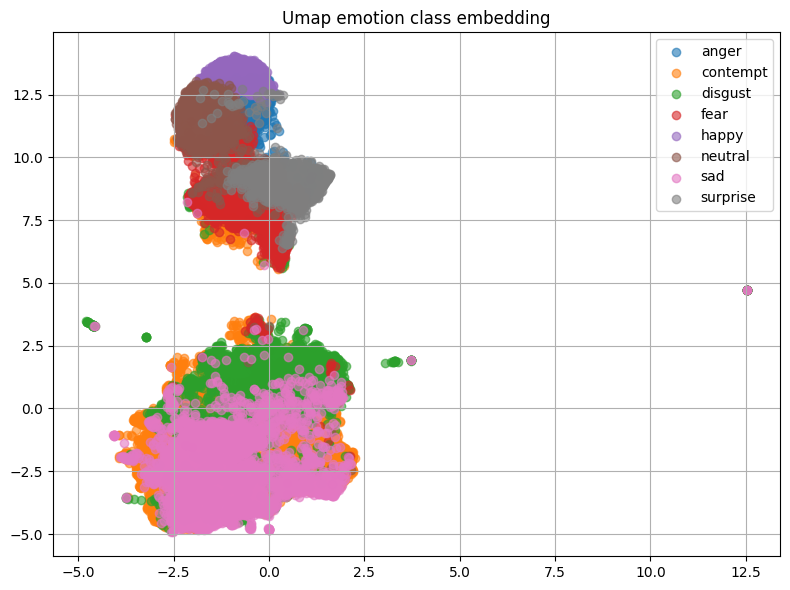

In [31]:
from sklearn.manifold import TSNE

tsne = TSNE(n_components=2, perplexity=10, random_state=42)
X_tsne_2d = tsne.fit_transform(X_embed)  # From the extract_mlp_embedding function

plt.figure(figsize=(8, 6))
for i in np.unique(cluster_labels):
    plt.scatter(X_tsne_2d[cluster_labels == i, 0], X_tsne_2d[cluster_labels == i, 1], label=le.classes_[i], alpha=0.6)
plt.title("TSNE Emotion embedding")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

import umap.umap_ as umap

umap_model = umap.UMAP(n_neighbors=15, min_dist=0.1, random_state=42)
X_umap_2d = umap_model.fit_transform(X_embed)

plt.figure(figsize=(8, 6))
for i in np.unique(cluster_labels):
    plt.scatter(X_umap_2d[cluster_labels == i, 0], X_umap_2d[cluster_labels == i, 1], label=le.classes_[i], alpha=0.6)
plt.title("Umap emotion class embedding")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

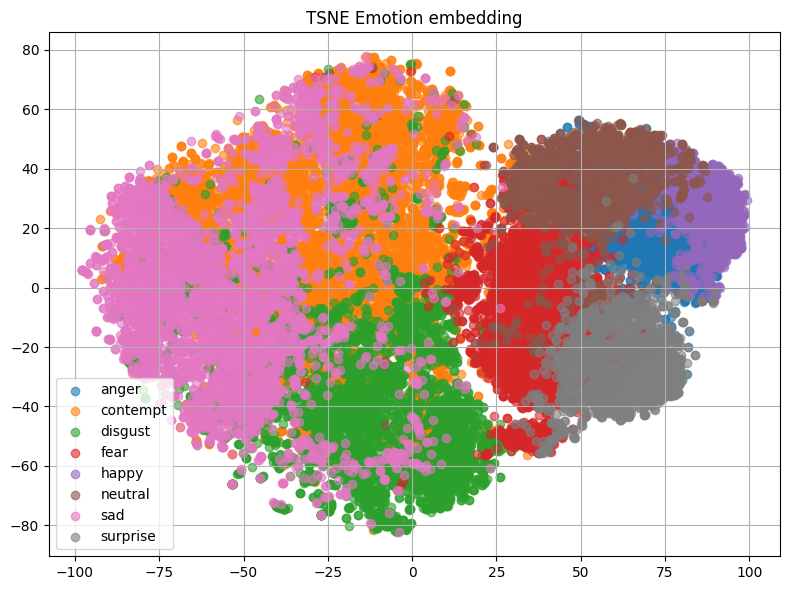

/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


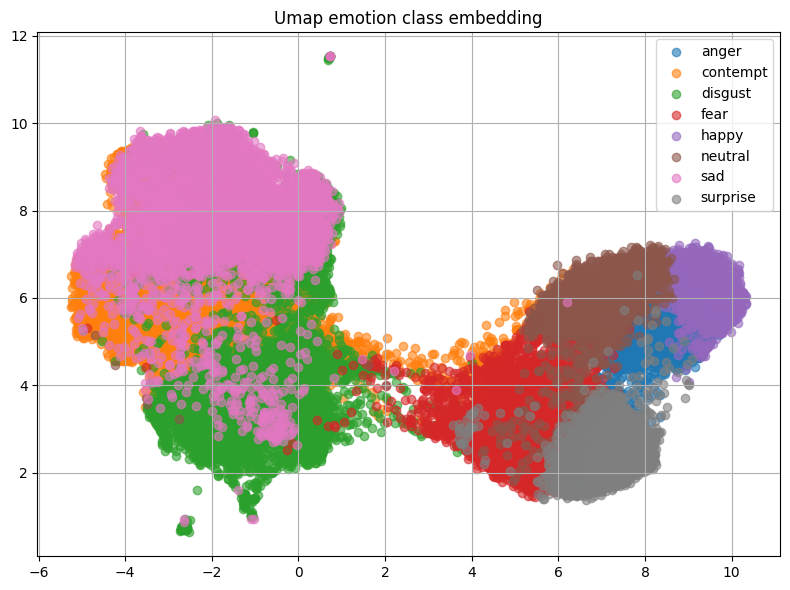

In [32]:
from sklearn.manifold import TSNE

tsne = TSNE(n_components=2, perplexity=30, random_state=42)
X_tsne_2d = tsne.fit_transform(X_embed)  # From the extract_mlp_embedding function

plt.figure(figsize=(8, 6))
for i in np.unique(cluster_labels):
    plt.scatter(X_tsne_2d[cluster_labels == i, 0], X_tsne_2d[cluster_labels == i, 1], label=le.classes_[i], alpha=0.6)
plt.title("TSNE Emotion embedding")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

import umap.umap_ as umap

umap_model = umap.UMAP(n_neighbors=50, min_dist=0.3, random_state=42)
X_umap_2d = umap_model.fit_transform(X_embed)

plt.figure(figsize=(8, 6))
for i in np.unique(cluster_labels):
    plt.scatter(X_umap_2d[cluster_labels == i, 0], X_umap_2d[cluster_labels == i, 1], label=le.classes_[i], alpha=0.6)
plt.title("Umap emotion class embedding")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

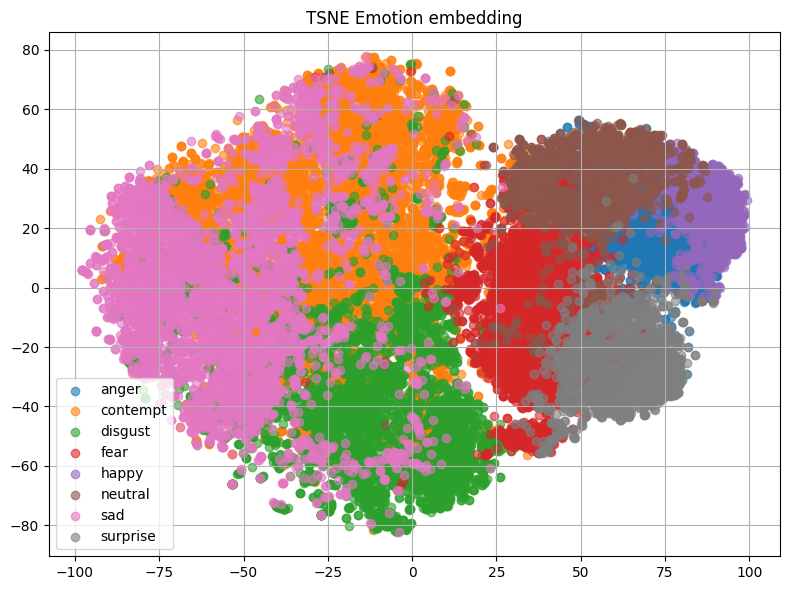

/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


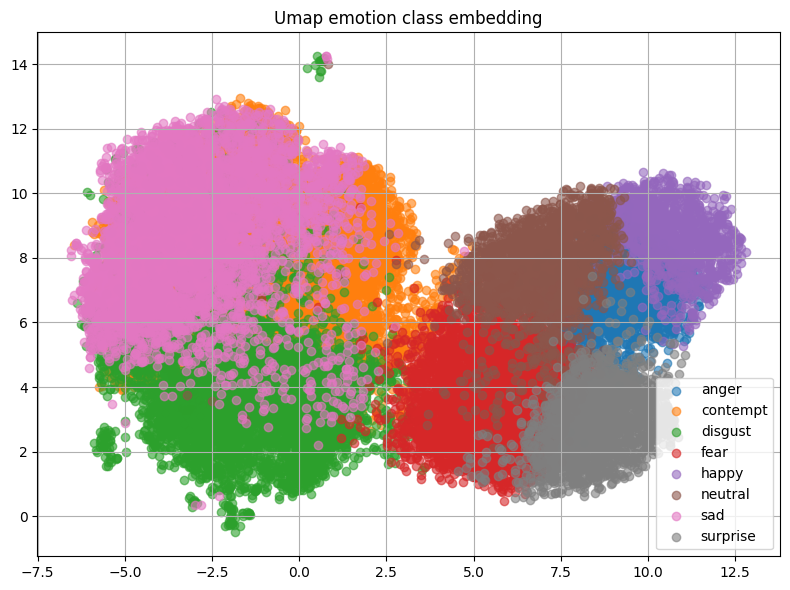

In [33]:
from sklearn.manifold import TSNE

tsne = TSNE(n_components=2, perplexity=30, random_state=42)
X_tsne_2d = tsne.fit_transform(X_embed)  # From the extract_mlp_embedding function

plt.figure(figsize=(8, 6))
for i in np.unique(cluster_labels):
    plt.scatter(X_tsne_2d[cluster_labels == i, 0], X_tsne_2d[cluster_labels == i, 1], label=le.classes_[i], alpha=0.6)
plt.title("TSNE Emotion embedding")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

import umap.umap_ as umap

umap_model = umap.UMAP(n_neighbors=50, min_dist=0.9, random_state=42)
X_umap_2d = umap_model.fit_transform(X_embed)

plt.figure(figsize=(8, 6))
for i in np.unique(cluster_labels):
    plt.scatter(X_umap_2d[cluster_labels == i, 0], X_umap_2d[cluster_labels == i, 1], label=le.classes_[i], alpha=0.6)
plt.title("Umap emotion class embedding")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

**1. Data Loading For CNN**

In this section,I load the dataset, including images and their corresponding emotion labels. We verify basic properties of the dataset, ensuring the images and labels are correctly loaded and aligned.

In [34]:
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.utils import to_categorical

# Load your grayscale image data
data = np.load('/content/drive/MyDrive/gray_image_data.npz')
X = data['X']  # shape: (29042, 96, 96, 1)
y = data['Y']

# Encode labels (e.g., happy → 0, sad → 1, etc.)
le = LabelEncoder()
y_encoded = le.fit_transform(y)
y_cat = to_categorical(y_encoded)  # for categorical crossentropy

# Train-test split
X_train, X_val, y_train, y_val = train_test_split(X, y_cat, test_size=0.2, stratify=y_encoded, random_state=42)

print("Data shapes:", X_train.shape, X_val.shape)


Data shapes: (23233, 96, 96, 1) (5809, 96, 96, 1)


**Making data augementation more divers to help generalize better, especially for emotions that vary slightly in appearance .**

In [35]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

from tensorflow.keras.preprocessing.image import ImageDataGenerator

datagen = ImageDataGenerator(
    rotation_range=15,
    zoom_range=0.2,
    width_shift_range=0.2,
    height_shift_range=0.2,
    horizontal_flip=True,
    brightness_range=[0.7, 1.3],
    shear_range=0.2
)


datagen.fit(X_train)  # Apply to training data only


In [36]:
from tensorflow.keras import Input
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dropout, Flatten, Dense, BatchNormalization, GlobalAveragePooling2D
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.regularizers import l2

callbacks = [
    EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True),
    ModelCheckpoint('best_cnn_model.h5', save_best_only=True, monitor='val_loss')
]


model = Sequential([
    Input(shape=(96, 96, 1)),

    Conv2D(32, (3, 3), activation='relu', padding='same'),
    Dropout(0.2),
    MaxPooling2D((2, 2)),
    BatchNormalization(),

    Conv2D(64, (3, 3), activation='relu', padding='same'),
    Dropout(0.2),
    MaxPooling2D((2, 2)),
    BatchNormalization(),

    Conv2D(128, (3, 3), activation='relu', padding='same'),
    Dropout(0.2),
    MaxPooling2D((2, 2)),
    BatchNormalization(),

    Conv2D(256, (3, 3), activation='relu', padding='same'),
    Dropout(0.2),
    MaxPooling2D((2, 2)),
    BatchNormalization(),


    GlobalAveragePooling2D(name = 'embedding_layer'),
    Dense(128, activation='relu', kernel_regularizer=l2(0.001)),
    Dropout(0.6),
    Dense(y_cat.shape[1], activation='softmax')
])


**Adding Class weight to ensure To handle Class Imbalance >>> In My data set Mostly Happy and Neutral Dominate**

In [37]:
from sklearn.utils.class_weight import compute_class_weight
import numpy as np

# Step 1: Calculate class weights
class_weights = compute_class_weight(
    class_weight='balanced',
    classes=np.unique(y_train.argmax(axis=1)),
    y=y_train.argmax(axis=1)
)

class_weights_dict = dict(enumerate(class_weights))


** Convolutional Neural Network (CNN) model to classify the facial emotions. Ideal for High Dimentionality Spatial Data Like Images .**

In [38]:
import tensorflow as tf
from tensorflow.keras.optimizers import Adam

optimizer = Adam( learning_rate = 0.0001) # Learning rate renduced to 0.0001


model.compile(
    optimizer= optimizer,
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

history = model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=20,
    batch_size=32,
    callbacks = callbacks,
    class_weight=class_weights_dict # Pay more attention to under-represented emotions
)



Epoch 1/20
726/727 ━━━━━━━━━━━━━━━━━━━━ 0s 306ms/step - accuracy: 0.1763 - loss: 2.2708

727/727 ━━━━━━━━━━━━━━━━━━━━ 240s 324ms/step - accuracy: 0.1764 - loss: 2.2705 - val_accuracy: 0.2195 - val_loss: 2.1406
Epoch 2/20
726/727 ━━━━━━━━━━━━━━━━━━━━ 0s 307ms/step - accuracy: 0.2996 - loss: 1.9845

727/727 ━━━━━━━━━━━━━━━━━━━━ 235s 324ms/step - accuracy: 0.2996 - loss: 1.9844 - val_accuracy: 0.2821 - val_loss: 1.9721
Epoch 3/20
726/727 ━━━━━━━━━━━━━━━━━━━━ 0s 307ms/step - accuracy: 0.3489 - loss: 1.8496

727/727 ━━━━━━━━━━━━━━━━━━━━ 235s 324ms/step - accuracy: 0.3489 - loss: 1.8495 - val_accuracy: 0.3555 - val_loss: 1.7844
Epoch 4/20
726/727 ━━━━━━━━━━━━━━━━━━━━ 0s 301ms/step - accuracy: 0.3927 - loss: 1.7576

727/727 ━━━━━━━━━━━━━━━━━━━━ 231s 318ms/step - accuracy: 0.3927 - loss: 1.7575 - val_accuracy: 0.3598 - val_loss: 1.7620
Epoch 5/20
726/727 ━━━━━━━━━━━━━━━━━━━━ 0s 303ms/step - accuracy: 0.4276 - loss: 1.6877

727/727 ━━━━━━━━━━━━━━━━━━━━ 232s 319ms/step - accuracy: 0.4276 - loss: 1.6877 - val_accuracy: 0.3577 - val_loss: 1.6468
Epoch 6/20
726/727 ━━━━━━━━━━━━━━━━━━━━ 0s 304ms/step - accuracy: 0.4585 - loss: 1.6106

727/727 ━━━━━━━━━━━━━━━━━━━━ 241s 332ms/step - accuracy: 0.4585 - loss: 1.6106 - val_accuracy: 0.4066 - val_loss: 1.5876
Epoch 7/20
727/727 ━━━━━━━━━━━━━━━━━━━━ 235s 324ms/step - accuracy: 0.4776 - loss: 1.5521 - val_accuracy: 0.3999 - val_loss: 1.6147
Epoch 8/20
726/727 ━━━━━━━━━━━━━━━━━━━━ 0s 309ms/step - accuracy: 0.4932 - loss: 1.5212

727/727 ━━━━━━━━━━━━━━━━━━━━ 236s 325ms/step - accuracy: 0.4932 - loss: 1.5212 - val_accuracy: 0.4612 - val_loss: 1.5555
Epoch 9/20
726/727 ━━━━━━━━━━━━━━━━━━━━ 0s 311ms/step - accuracy: 0.5134 - loss: 1.4835

727/727 ━━━━━━━━━━━━━━━━━━━━ 238s 328ms/step - accuracy: 0.5134 - loss: 1.4834 - val_accuracy: 0.4529 - val_loss: 1.5028
Epoch 10/20
726/727 ━━━━━━━━━━━━━━━━━━━━ 0s 308ms/step - accuracy: 0.5285 - loss: 1.4312

727/727 ━━━━━━━━━━━━━━━━━━━━ 236s 324ms/step - accuracy: 0.5285 - loss: 1.4312 - val_accuracy: 0.4794 - val_loss: 1.4591
Epoch 11/20
726/727 ━━━━━━━━━━━━━━━━━━━━ 0s 306ms/step - accuracy: 0.5429 - loss: 1.3945

727/727 ━━━━━━━━━━━━━━━━━━━━ 234s 323ms/step - accuracy: 0.5429 - loss: 1.3945 - val_accuracy: 0.4798 - val_loss: 1.4012
Epoch 12/20
726/727 ━━━━━━━━━━━━━━━━━━━━ 0s 310ms/step - accuracy: 0.5585 - loss: 1.3671

727/727 ━━━━━━━━━━━━━━━━━━━━ 237s 326ms/step - accuracy: 0.5585 - loss: 1.3671 - val_accuracy: 0.5102 - val_loss: 1.3237
Epoch 13/20
726/727 ━━━━━━━━━━━━━━━━━━━━ 0s 309ms/step - accuracy: 0.5685 - loss: 1.3315

727/727 ━━━━━━━━━━━━━━━━━━━━ 237s 325ms/step - accuracy: 0.5685 - loss: 1.3316 - val_accuracy: 0.5225 - val_loss: 1.3066
Epoch 14/20
727/727 ━━━━━━━━━━━━━━━━━━━━ 235s 324ms/step - accuracy: 0.5689 - loss: 1.3139 - val_accuracy: 0.4815 - val_loss: 1.4364
Epoch 15/20
727/727 ━━━━━━━━━━━━━━━━━━━━ 231s 317ms/step - accuracy: 0.5865 - loss: 1.2933 - val_accuracy: 0.4794 - val_loss: 1.4180
Epoch 16/20
727/727 ━━━━━━━━━━━━━━━━━━━━ 225s 310ms/step - accuracy: 0.5975 - loss: 1.2414 - val_accuracy: 0.5020 - val_loss: 1.4049
Epoch 17/20
726/727 ━━━━━━━━━━━━━━━━━━━━ 0s 293ms/step - accuracy: 0.6025 - loss: 1.2305

727/727 ━━━━━━━━━━━━━━━━━━━━ 225s 309ms/step - accuracy: 0.6026 - loss: 1.2304 - val_accuracy: 0.5481 - val_loss: 1.2593
Epoch 18/20
727/727 ━━━━━━━━━━━━━━━━━━━━ 231s 317ms/step - accuracy: 0.6078 - loss: 1.2099 - val_accuracy: 0.5428 - val_loss: 1.2603
Epoch 19/20
726/727 ━━━━━━━━━━━━━━━━━━━━ 0s 296ms/step - accuracy: 0.6295 - loss: 1.1779

727/727 ━━━━━━━━━━━━━━━━━━━━ 227s 312ms/step - accuracy: 0.6295 - loss: 1.1779 - val_accuracy: 0.5648 - val_loss: 1.2239
Epoch 20/20
726/727 ━━━━━━━━━━━━━━━━━━━━ 0s 293ms/step - accuracy: 0.6335 - loss: 1.1578

727/727 ━━━━━━━━━━━━━━━━━━━━ 225s 309ms/step - accuracy: 0.6334 - loss: 1.1578 - val_accuracy: 0.5605 - val_loss: 1.2045


**Confusion_matrix with Visualization And Learning_Curve Graph**

182/182 ━━━━━━━━━━━━━━━━━━━━ 12s 67ms/step


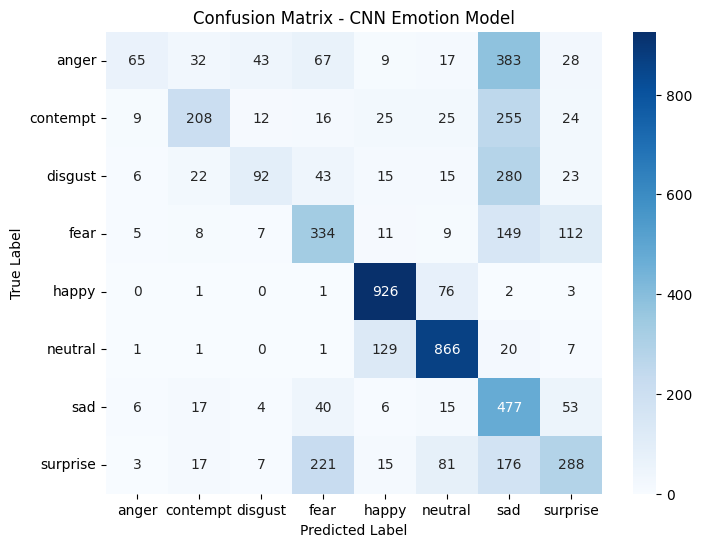

              precision    recall  f1-score   support

       anger       0.68      0.10      0.18       644
    contempt       0.68      0.36      0.47       574
     disgust       0.56      0.19      0.28       496
        fear       0.46      0.53      0.49       635
       happy       0.82      0.92      0.86      1009
     neutral       0.78      0.84      0.81      1025
         sad       0.27      0.77      0.40       618
    surprise       0.54      0.36      0.43       808

    accuracy                           0.56      5809
   macro avg       0.60      0.51      0.49      5809
weighted avg       0.62      0.56      0.54      5809



In [39]:
import numpy as np
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns
import matplotlib.pyplot as plt

# Predict
y_pred_probs = model.predict(X_val)
y_pred = np.argmax(y_pred_probs, axis=1)
y_true = np.argmax(y_val, axis=1)

# Confusion matrix
cm = confusion_matrix(y_true, y_pred)

plt.figure(figsize=(8,6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=le.classes_,
            yticklabels=le.classes_)
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix - CNN Emotion Model")
plt.show()

# Classification report
print(classification_report(y_true, y_pred, target_names=le.classes_))


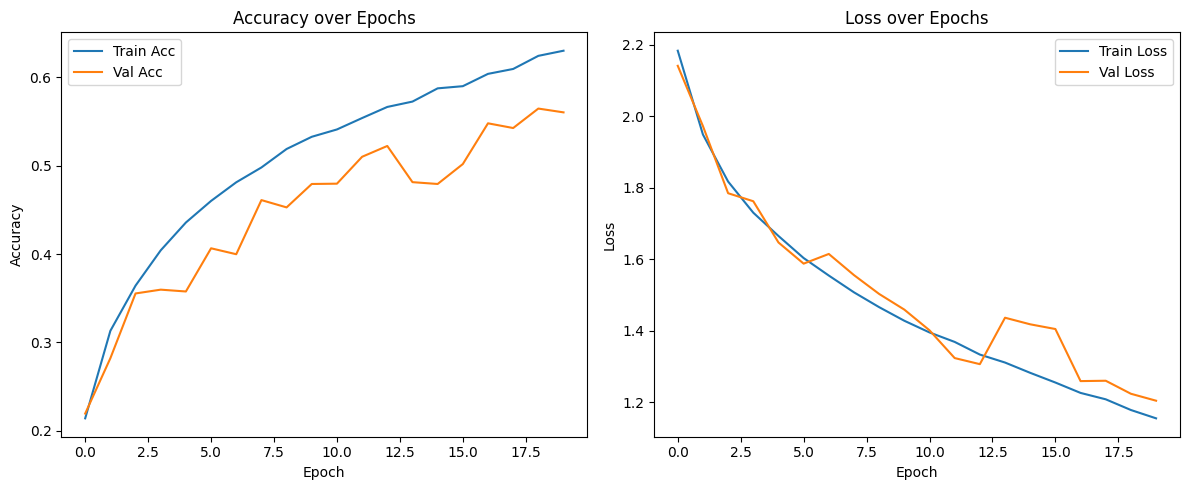

In [40]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 5))

# Accuracy plot
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Acc')
plt.plot(history.history['val_accuracy'], label='Val Acc')
plt.title('Accuracy over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

# Loss plot
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.title('Loss over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()
